# Exploratory dataset visualization

<img src="http://reconstrue.com/assets/images/reconstrue_combo_mark.svg" width="266px"/>

This notebook performs initial exploratory data analysis (read: get eyes on data) of a brightfield microscopy image stack of a biocytin-stained neuron. The image stacks are from the Allen Institute's Brightfield Auto-Reconstruction Challenge. For more information see [brightfield neuron reconstruction challenge.ipynb](http://reconstrue.com/data_sources/allen_institute/brightfield_neuron_reconstruction_challenge.html).

<img src="http://reconstrue.com/projects/brightfield_neurons/demo_images/647289876.minip_colored_turbo.tif.cropped.png"/>


## Legal

This code is [licensed by Reconstrue under the Apache 2.0 License](https://github.com/reconstrue/brightfield_neuron_reconstruction_on_colab/blob/master/LICENSE).


In [0]:
# Copyright 2019-2020 Reconstrue Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Introduction

This notebook downloads and visualizes the cells in The Allen Institute's BioImage 2019 Brightfield Challenge dataset, which consists of image stacks and reconstructed skeletons of neurons from mouse brains.

Given a random dataset, the first thing a data scientist would do is to take an initial inventory of the files, which is covered in a separate notebook, [dataset_manifest.ipynb](https://colab.research.google.com/drive/1_zv9mgrKVCMa5jTnN1CADZFRi3UES6_P#scrollTo=ss0gFZ_eBJSG). The result of that notebook is a convenience file, [cells_manifest.json](http://reconstrue.com/projects/brightfield_neurons/challenge_dataset/specimens_manifest.json), which is used in this notebook, in order to make the code cleaner and simpler.

The main goal of this notebook is to get eyes on the data. Additionally, it explores what can be done to visualize brightfield micoscopy data on Colab. That is, the Jupyter notebooks in this project have visualization based on web technologies that have been optimized for deployment on Colab.

### Table of contents

On Colab there is a detailed table of contents in the colapseable left side bar. Here is a high level summary:

- [Part 1: Set up](#scrollTo=mk2DQjlkrWu1)
- [Part 2: Explore individual TIFF files](#scrollTo=24U3mpBZGJeh)
- [Part 3: Explore skeleton file](#scrollTo=D94SAWdlLVag)
- [Part 4: Explore full stack](#scrollTo=sH-bZDsfv9Ir)
- [Part 5: Juxtapose stack projection and Skeleton](#scrollTo=uYssqpx4qsIo)

#### Utility and scope of this notebook
This notebook vizualizes raw input images (a brightfield microscopy z-image stack) and pre-generated skeletons reconstructed from the image stack (the SWC files). This notebook does not create reconstructions, rather it juxtaposes image stacks and skeletons.

This notebook just does initial data analysis; it does not generate ML-based reconstructions. This notebook is written as if a data scientist without domain knowledge of the physics of brightfield microscopy nor neuroscience were given the Challenge data raw (i.e. just 2.5 TB of image files and SWC files in a bucket) and needed to get at least an overview of the data, before subsequently performing the main data analysis (which in the case of the Challenge is to generate SWC files for those neurons in the dataset that do not already have SWCs).

In performing this initial data visualization exercise, we will recapitulate various microscopy imaging techniques, on Colab. The data viz number crunching happens on Colab. Additionally, the resulting data and images are viewed within the notebook on Colab (web tech on a web page). This is all just Python in Jupyter, tuned for deployment on Colab.

## Goal: juxtapose image stack and skeleton

One visualization to take as inspiritation is the following image set, taken from the Allen Cell Types Database's [Cell Morphology And Histology](http://help.brain-map.org/download/attachments/8323525/CellTypes_Morph_Overview.pdf?version=4&modificationDate=1528310097913&api=v2) technical white paper, page 11.

<img src="http://reconstrue.com/projects/brightfield_neurons/allen_morphology_viz.png" width="500px"/>

Starting the upper left of the four panels, the Minimal Intensity Projection (MinIP image) is the 3D image stack projected down to 2D, in a fashion that brings out neurites buried in the stack. Next in the upper right panel, the MinIP is inverted. In the next row, the blue dendrite and the red axon skeletons are overlaid on the white-ish neurite pixels in the inverted MinIP.

Therefore, one of the things this notebook can produce is images such as the following example, which was generated for specimen 

<img src="http://reconstrue.com/projects/brightfield_neurons/demo_images/651806289_allen_styled.png" width="400px"/>








### Strategy: process cells individually

The entire dataset is about 2.5 terabyte (TB), containing over one hundred cells' data. The file system on Colab has ~300 MB of free working space.

In order to run on Colab, the code will have to deal with the limits of the file system size and the twelve hour execution time limit. Therefore, this notebook downloads and processes only a single cell per run, thereby reducing the input data load down to a worst case of 60MB.

The data is downloaded from the Allen Institute directly to Colab. The image processing is executed on Colab. 



### Visualizations
Various visualizations are generated, for viewing over the web:
- Minimum intensity projections
- Various colorizations
- Downsampled image stack viewer
- Z-stack as animated GIF
- Movie (timeline is stack index)
- Images generated for distribution over Twitter

The outline of what happens in this notebook is:
- User specifies a cell ID
- Code downloads image stack
- Code dumps metadata on a sample .tif file
- Code generates a minimal intensity projection (i.e. 3D => 2D)
- Code generates web friendly animations of image stack 


---
## Part 0: Pre-run user config

Part 0 is the only part of the notebook that requires user input. 
- Optionally authorize access to your Google Drive storage 
- Optionally pick which cell to process
- Then execute the notebook with a `Runtime -> Run all

The rest of the notebook should run by itself. There is a default cell ID, 651806289, which has the smallest dataset. This means that folks can just `Run all` out of the box and the code will run.


### Specify which specimen to visualize

These Brightfield Challenge image stacks are large, approximately 6GB to 60GB. Given the size of the Colab file system, the strategy here is to process one specimen at a time.

This notebook only needs one constant set: the ID of the specimen to process. The idea is that this code can be used on any specimen in the Brightfield Challenge dataset, simply by changing the `specimen_id`.

The specimen_id list is sorted by size, smallest first.
- Smallest training specimen: 651806289, 291 files, 6.0 GB
- Smallest testing specimen: 665856925, 281 files, 8.6 GB
- Biggest is ~60 GB 

Note, Colab has an extension to Jupyter called Forms. The `specimen_id` dropdown on the right below is a Form element.

In [0]:
#Pick a specimen to download for processing
specimen_id = "651806289" #@param ["651806289", "647289876", "651748297", "647244741", "713686035", "647247980", "649052017", "650917845", "672278613", "654221379", "676633030", "726555942", "706002308", "664466860", "739291676", "699207642", "669371214", "654591451", "836350796", "651511374", "729522604", "696228200", "651790667", "728251151", "668664690", "651834134", "673066511", "652113069", "821560343", "715286106"]
# TODO: list all 105 training neurons, sorted by size
print("specimen_id = %s" % specimen_id)

In [0]:
# TODO: deal with any authorization hassles that might require input.
# - If gDrive then trigger that up here, at the start, while have users attention.
# - Use getpass()
# - More generally, it's about deciding if and which export dest

**TODO:** Explain that this notebook is optimized for fullscreen viewing on Colab.
- a little screen capture of HOWTO enter fullscreen, and one on hide/show form. 
- Explain that if browser's text is zoomed, will mess up the layout.


---
<a id="part_1"></a> 
## Part 1: Set up

Code in this section sets up shop and then downloads a single cell's data to a cache on the local file system.


#### Request maximum file system size
Colab provides a file system of 50GB (or 360GB if the runtime is configured to use a GPU). So, you might want to set up a GPU for the runtime if you are planning on working on a large neuron image stack. 

To select a GPU runtime backend, in the Runtime menu, select "Change runtime type" and for "Hardware accelleration" select GPU. To check the  file system size, use `!df -h`.



In [0]:
# TODO: code that check that FS is set to ~360 MB, not ~50MB. Generate a warning if not so. 
# Don't halt, b/c 50MB will work for many of the specimens.

### Installations

The AllenSDK has SWC manipulation code.

In [0]:
!pip --quiet install allensdk

### All imports

Import everything that will be needed on this notebook, once, all in one cell.

In [0]:
import boto3
import datetime
import glob
import google
import ipywidgets
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly
import time
import requests
import seaborn as sns
import skimage
import sys
import urllib
import IPython
import PIL

from IPython.display import HTML, display
from PIL import Image
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import minmax_scale



# TODO: just import google.colab; kill off other from google.colab's: 
# from google.colab import output
from google.colab import widgets
from google.colab import files
import plotly.graph_objects as go # TODO: lame alias, confusing


**Define utilities**

Dictionary `conclusions` is used throughout the notebook as a place to gather conclusions, sort of a globals namespace.

In [0]:
conclusions = {}

Set up Seaborn, a chart & plot package based on Matplotlib.

In [0]:
sns.set()
sns.set_style("white")
sns.despine() # TODO: no effect

Turbo colormap

The Turbo colormap is a new and improved Jet, introduced in a mid-2019 Google AI blog post, [Turbo, An Improved Rainbow Colormap for Visualization]( https://ai.googleblog.com/2019/08/turbo-improved-rainbow-colormap-for.html). The following juxtaposition illustrates Jet's flaws (images are from Google's post).

**Turbo:**<br/>
<img src="https://1.bp.blogspot.com/-T2q4LV_VaTA/XVWYfIwvOVI/AAAAAAAAEcQ/aUciAXkV_QAuuZ1y5DcbstBcDr-Umw4kgCLcBGAs/s1600/image10.png"/>

**Jet:**<br/>
<img src="https://1.bp.blogspot.com/-sPUhv6GioHA/XVWYnfT5VcI/AAAAAAAAEcU/QI-YZsI3h7sWeAhCAMc47HvZ3_mXOXm3gCLcBGAs/s1600/image6.png" />

Quoting Google's post: "Turbo is a slot-in replacement for Jet, and is intended for day-to-day tasks where perceptual uniformity is not critical, but one still wants a high contrast, smooth visualization of the underlying data."


In [0]:
# See https://gist.github.com/mikhailov-work/ee72ba4191942acecc03fe6da94fc73f
turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
turbo_cmap=ListedColormap(turbo_colormap_data)

A progress bar that works on Colab:


In [0]:
def progress(value, max=100):
  return HTML("""
    <progress
      value='{value}'
      max='{max}',
      style='width: 100%'
    >
      {value}
    </progress>
    """.format(value=value, max=max))
  

A slider UI control:

In [0]:
class Slider:
  def __init__(self, value=0, min=0, max=100, step=1):
    self.value = value
    self.min = min
    self.max = max
    self.step = step
    
  def _repr_html_(self):
    name = id(self)
    return f"""
    <input type="range" id="in{name}"
     min="{self.min}" max="{self.max}" step="{self.step}"
     value="{self.value}"
     oninput="out{name}.value=in{name}.value"
     onchange="
       google.colab.kernel.invokeFunction(
         'set_var', [{name}, this.valueAsNumber],
         {{}})
     "
    >
    <output id="out{name}">{self.value}</output>
    """


Audio indicators of progress, sourced from [Soundjay](https://www.soundjay.com/bell-sound-effect.html). E.g.s:
- a bell for when data download had completed
- a bell for when all processing completed


In [0]:
def get_audio_file(filename, url):
  bells_dest_dir = "/content/tmp/"
  dest_filename = os.path.join(bells_dest_dir, filename)
  if not os.path.exists(bells_dest_dir):
    os.mkdir(bells_dest_dir)
  response = requests.get(url)
  with open(dest_filename, 'wb') as f:
    f.write(response.content)
  return dest_filename

jingle_bell_filename = get_audio_file("jingle_bell.mp3", "https://www.soundjay.com/misc/bell-ringing-05.mp3")
chime_bell_filename = get_audio_file("chime_bell.mp3", "https://www.soundjay.com/misc/bell-ring-01.mp3")
rimshot_filename = get_audio_file("rimshot.mp3", "https://ia800203.us.archive.org/1/items/rimshot_78/Sfx-RimshotMp3.mp3")

A file size pretty printer for human legibility of big files:

In [0]:
# https://stackoverflow.com/a/1094933
def sizeof_fmt(num, suffix='B'):
  for unit in ['','K','M','G','T','P','E','Z']:
    if abs(num) < 1024.0:
      return "%3.1f%s%s" % (num, unit, suffix)
    num /= 1024.0
  return "%.1f %s%s" % (num, 'Yi', suffix)

A resizable image viewer (based on Plotly) with zoom and pan that works well in fullscreen mode on Colab:

In [0]:
def display_image(image_to_show, scale_factor): 
  # TODO: want to set viewport dimensions to output cell, not image_to_show 

  # Create figure
  fig = go.Figure()
    
  # Constants
  h, w = image_to_show.size
  img_width = h
  img_height = w

  #scale_factor = 0.15 
  # TODO: want scale_factor sensitive to cell/window width, else controls off screen to right.
  # There is also Colab API for checking and requesting output size. What about when in full screen; there is resize logic already

  # Add invisible scatter trace.
  # This trace is added to help the autoresize logic work.
  fig.add_trace(
    go.Scatter(
    x=[0, img_width * scale_factor],
    y=[0, img_height * scale_factor],
    mode="markers",
    marker_opacity=0
   )
  )
    
  # Configure axes
  fig.update_xaxes(
    visible=True,
    showgrid=False,
    range=[0, img_width] #range=[0, img_width * scale_factor]
  )
    
  fig.update_yaxes(
    visible=True,
    showgrid=False,
    range=[0, img_height],#range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
  )
    
  # Add image
  fig.update_layout(
    images=[go.layout.Image(
      x=0,
      sizex=img_width, # * scale_factor,
      y=img_height, # * scale_factor,
      sizey=img_height, # * scale_factor,
      xref="x",
      yref="y",
      opacity=1.0,
      layer="below",
      sizing="stretch",
      source=image_to_show)] #input_image)] # "https://raw.githubusercontent.com/michaelbabyn/plot_data/master/bridge.jpg")]
  )
    
  # Configure other layout
  fig.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
  )
    
  fig.show()


### Data cache and workspace
The data workspace is a directory on the Colab VM's file system wherein all files produced by this notebook are stored. That includes file produced by downloading the challenge dataset to a VM-local cache. In code, the workspace is referred to by a variable `data_dir` which by default is set to `/content/brightfield_data/`. A sub-folder for raw input data is also contained there; it's full path is kept in a variable, `dataset_cache_dir`.

**Note:** On Colab there is a file system navigator in the left side panel, in the `Files` tab. That can be used to see what files this notebook is working with. All project files will be the directory `/content/brightfield_data`.

### Rationale
Organizing the data_dir this way has multiple benefits:
- The dataset is too big (2.5 TB) for the Colab VM's file system, so simply download specimens separately
- Caching bypassed unneccesary repeat downloads
- The generated files in `data_dir/built/` provide a static website for the full dataset

About that last point: by repeatedly running this notebook for each specimen, the files in `data_dir` can be loaded into a static web server (the simplest kind of web server) and viewed in a web browser. So, this notebook produces various visualizations and the files in data_dir is the content for a web altas of the specimens contain the produced visualizations. In other words, those file do not require Jupyter to be viewed.

### Workspace file system structure
The data workspace is organized within a single directory, the `data_dir`. Normally, `data_dir` is set to "/content/brightfield_data/." So, from the root of the file system:

```    
- /content/
  - brightfield_data/ 
    - dataset_cache/
    - built/
```    

`data_dir` has a sub-directory, `dataset_cache`, which is the download cache of files from the dataset in Wasabi. The directory structure on Wasabi is mirrored in `dataset_cache`. The files are write protected to suggest they should not be modified after initial download/creation.

The `built/` directory is where all generated files are parked by this notebook.

The `built` directory's childern are all directories, which have names set to the specimen_id whose data is contained within each directory. (In other words, specimens in `TEST_DATA_DIR` are pulled up to root in `built`; all are treated the same in the web catalog.)

Using the above file system layout, artifacts from multiple specimens can coexist on the local file system simultaneously without overwriting each other. In other words this code is designed to do multiple runs of single specimens and not have files overwriting each other.

In [0]:
# Set up data_dir with a specimens_manifest.json

data_dir = "/content/brightfield_data/"
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

dataset_cache_dir = os.path.join(data_dir, "dataset_cache")
# TODO: will not work for TEST_DATA_SET. Use manifest prefix, not specimen_id
image_stack_src_dir = os.path.join(data_dir, "dataset_cache", specimen_id)
build_output_dir = os.path.join(data_dir, "built", specimen_id)
print("Image stack will be downloaded to:\n" + image_stack_src_dir)
print("Generated artifacts will be saved in:\n" + build_output_dir)

# Look for specimens_manifest.json in root of data workspace, if not present, 
# download one from reconstrue.com.
#
# Note: this way allows someone to reuse this notebook to process their own
# image stacks, by providing their own specimen_manifest.json. But this works
# for demoing as-is on Colab.
manifest_file_name = os.path.join(data_dir, "specimens_manifest.json")
if not os.path.exists(manifest_file_name):
  manifest_url = "http://reconstrue.com/projects/brightfield_neurons/challenge_dataset/specimens_manifest.json"
  print("Downloading dataset specimen_manifest from reconstrue.com")
  manifest_file = open(manifest_file_name, "wb")
  with urllib.request.urlopen(manifest_url) as response:
    manifest_file.write(response.read())
  
# Load the JSON manifest
with open(manifest_file_name) as manifest_file:
  specimens_manifest = json.load(manifest_file)

print( "specimens_manifest.json contains %d specimens" % len(specimens_manifest))

specimen = specimens_manifest[specimen_id]
z_stack_height = len(specimen["image_stack"])
specimens_dataset_prefix = specimen["bucket_prefix"]

### Download data

The dataset is stored on [Wasabi](https://wasabi.com/), as can be seen below in `endpoint_url`. `boto3` is AWS' Python SDK. Wasabi built their service to work with `boto3`.

Set up data connection to Challenge dataset (image stacks and SWCs):

In [0]:
s3 = boto3.resource('s3',
     endpoint_url = 'https://s3.us-west-1.wasabisys.com',
     aws_access_key_id = '2G7POM6IZKJ3KLHSC4JB',
     aws_secret_access_key = "0oHD5BXPim7fR1n7zDXpz4YoB7CHAHAvFgzpuJnt")  
bucket = s3.Bucket('brightfield-auto-reconstruction-competition')


The smallest specimen, `651806289`, has a dataset of 6.1 GB. On a good day transfering that from Wasabi to Colab takes about 1 minute. On a bad day 10 minutes has been observed.

This code only downloads a file if the file is not already in the local file cache. This way after disconnects, one can just `Runtime|Run all` after reconnect and not have to repeat the long download.

In [0]:
# For a given specimen_id, download its "subtree" of the dataset bucket. 

# Set up a progress indicator for this slow task:
progressIndicator = display(progress(0, z_stack_height), display_id=True)
progressIndicator_count = 0

destination_directory = os.path.join(data_dir, "dataset_cache", specimens_dataset_prefix) 
if not os.path.exists(destination_directory):
  os.makedirs(destination_directory)

start = time.time()
print("Start downloading at: " + time.ctime(start))
print("Specimen has %d files, totaling %s" % (z_stack_height, sizeof_fmt(specimen["bytes"])))
print("Downloading files from dataset directory:\n  " + specimens_dataset_prefix)
print("Downloading to:\n  " + destination_directory)

imagestack_bytes = 0
imagestack = []
swc_key = None
files_downloaded = 0

for stack_file in specimen["image_stack"]:
  progressIndicator_count += 1
  progressIndicator.update(progress(progressIndicator_count, z_stack_height))
  dest_file_name = os.path.join(dataset_cache_dir, stack_file)
  # print("Checking for: %s" % dest_file_name)
  if not os.path.exists(dest_file_name):
    files_downloaded += 1
    with google.colab.output.use_tags("progress"):
      google.colab.output.clear(output_tags="progress")
      sys.stdout.write("Downloading " + stack_file)
      sys.stdout.flush()
    bucket.download_file(stack_file, dest_file_name)
    # TODO: set to read-only so as to enforce "no changing orig files"

swc_dest = os.path.join(dataset_cache_dir, specimen["swc"])
if not os.path.exists(swc_dest):
  bucket.download_file(specimen["swc"], swc_dest)

end = time.time()
google.colab.output.clear(output_tags="progress")
print("Number of files downloaded: %d" % files_downloaded)
print("Download time: " + "%s seconds" %(int(end - start)))


**Play a bell**

Long, boring data downloads can happen in the backgroud; this bell rings to alert that the download has completed.


In [0]:
IPython.display.Audio(jingle_bell_filename, autoplay=True)

**Check download size**


In [0]:
# Get stats on the data_dir on file system
data_dir = data_dir # TODO: why this line of code?

if os.path.isdir(data_dir):
  !du -h {data_dir}
  !echo Number of TIFF files in {specimen_id} source image stack:
  !ls -1 {image_stack_src_dir}/*.tif|wc -l
else:
  print("Do not seem like data directory has been created yet.")
  print("Was looking for it at: " + data_dir)

---

## Part 2: Explore individual image files

Each cell's data consists of two components:
- the image stack
- the optional skeleton file

The image stack is made up of an array of 2D images arrayed along depth axis. Image stacks have a few hundred images; the skeleton file – if present – is a single file.

So, this part first explores individual image files, before later part process the entire image stack.

#### Image file stats and metadata

Although a format, TIFF files come in many variants. In order to determine what flavor of TIFF is in the dataset, pick some image from the stack and dump statistics on it.

In [0]:
# Assumes all images in stack are same size, explore one from 
# the middle of the image stack.

# TODO: this should be a slider, which defaults to mid stack
mid_index = int(len(specimen["image_stack"])/2)
mid_image = specimen["image_stack"][mid_index]
mid_depth_filename = os.path.join(dataset_cache_dir, mid_image) #random.choice(tif_files)
byte_size = sizeof_fmt(os.path.getsize(mid_depth_filename))
print("A image from the middle of the image stack:")
print(byte_size + " = " + mid_depth_filename )

***Read internal metadata***

First, dump out `info` values



In [0]:
from PIL import Image

try:
  with Image.open(mid_depth_filename) as im:
    print("file: " + mid_depth_filename)
    print("format: " + im.format)
    print("WxH: " + "%dx%d" % im.size)
    print("mode: " + im.mode) # mode is RGB or L
    #print(im.info)
    for k, v in im.info.items():
      print(k + ": " + str(v) ) #+ im.info[factoid][1]) #+ factoid[1])# + factoid.value)
    conclusions["plate_size"] = im.size
except IOError:
  print("unable to open %s" % mid_depth_filename)



Note, for the `mode` the value of [`L` means "8-bit pixels, black and white"]( (https://pillow.readthedocs.io/en/5.1.x/handbook/concepts.html).

Next, dump out tags


In [0]:
from PIL import Image
from PIL.TiffTags import TAGS

# resize tif from 22.3MB to 223.KB
# https://stackoverflow.com/a/54526478
with Image.open(mid_depth_filename) as img:
    meta_dict = {}
    for key in img.tag:      # don't really need iterkeys in this context
        meta_dict[TAGS.get(key,'missing')] = img.tag[key]

# print( meta_dict)
for k, v in meta_dict.items():
  print(k + ": " + str(v))

Notice the dimensions of the image. A couple hundred of those per image stack, times over 100 specimens... gets to ~2.5 TB.

### Image stack viewer

This [Plotly-based](https://plot.ly/python/images/#zoom-on-static-images) image viewer can:
- Zoom, crop, and pan: [Plotly UI: pan and zoom controls](https://help.plot.ly/zoom-pan-hover-controls/)
- Download snapshot of current view as PNG

**TODO:** Add screenshots. 

**TODO:** Rewrite to:
- [x] Drop the static view. No value except axis
- [x] Plotly view w/ axes
- [ ] A depth slider, as in downsampled section 
- [ ] colorization 
  - [ ] should just be a [dropdown](https://github.com/reconstrue/brightfield_neuron_reconstruction_on_colab/issues/61) for a single colormap
  - [x] Loose the 4-up until MinIP.


In [0]:
# TODO:
# if the images are too big, Colab will "runtime disconnect"
# Seems that the max image size that works is somewhere around 20MB.
# E.g. 654221379 = 31.5MB image file
#
# See https://github.com/reconstrue/brightfield_neuron_reconstruction_on_colab/issues/58



In [0]:
# TODO: want this scale_factor gone. 
# Find max size file allowed in pre-run cache,
# gen file of that size for later kernel-less viewing will work.
scale_factor = 0.23 #@param {type:"slider", min:0.05, max:1, step:0.01}

# TODO: add in colormap
color_map = "gray" #@param ["gray", "inverted", "turbo", "cubehelix", "viridis"]

def set_z_index(Z):
    #print(z)
    #plt.imshow(throtle_scale(image_stack[Z]))
   pass # return Z
#print("Z-index")
ipywidgets.interact(set_z_index, Z=(0, 500))
pass


image_to_show = PIL.Image.open(mid_depth_filename)
#print("Downloading to browser one %s image file" % sizeof_fmt(os.path.getsize(mid_depth_filename)))
display_image(image_to_show, scale_factor)


### Banding in the data

On a semi-local level there is a banding in the data which the code will have to deal with. To see an example, crop in on a random cell's soma. (Here Allen Institute Cell Type DB cell 713686035 is used as an example.) Then using `minmax_scale()` stretch that subset of the original intensities to the full potential range of 0 -- 255. Finally, colormap to Turbo. The vertical bands alternating yellow and red are an artifact of the image acquisition which the reconstruction algorithms will need to deal with.


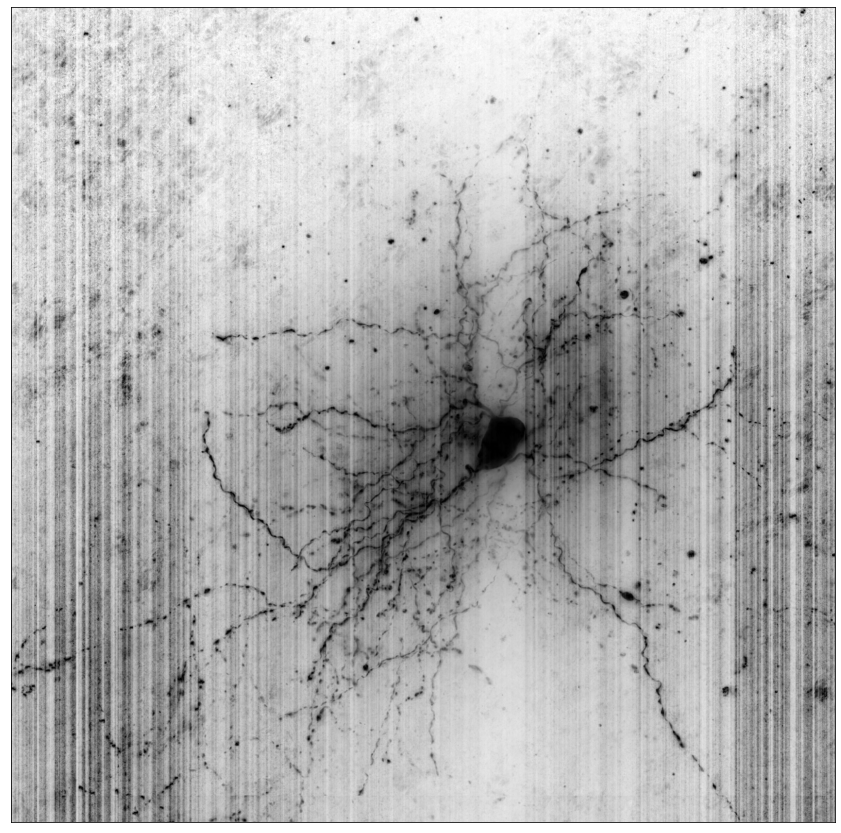

In [20]:
import os
import skimage.io
import PIL.Image
from sklearn.preprocessing import minmax_scale

# Download cell 713686035's stack minimum intensity projection (minip)
!wget -q --output-document=minip.tiff http://reconstrue.com/projects/brightfield_neurons/demo_images/713686035.minip_original.tif
minip_filename = os.path.join(os.getcwd(), 'minip.tiff')
minip = PIL.Image.open(minip_filename)

# How much to crop from each side: ((top, bottom), (left, right))
crop_box_for_713686035 = ((2000,2000),(1750,2250))
projection_orig = skimage.io.imread(minip_filename)
minip_cropped = skimage.util.crop(projection_orig, crop_box_for_713686035)
scaled = minmax_scale(minip_cropped) * 255

minip_cropped_pil = PIL.Image.fromarray(scaled)

plt.figure(figsize=(15,15))
fig = plt.imshow(minip_cropped_pil, cmap = plt.cm.gray) 
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)



---
## Part 3: Explore skeleton file

First thing to do is check out the skeleton data structure in the SWC file, if there is a pre-generated SWC file for this specific cell availabe. 

In this section the skeleton will be visualized in isolation, not superimposed on the images off the microscope. Later in this notebook superimpositions will be explored, after having explored the images in isolation.

### Explore SWC file

SWC is an ASCII text file format. 

[AllenSDK on SWC file format spec](https://alleninstitute.github.io/AllenSDK/cell_types.html). 
>The SWC file format is a white-space delimited text file with a standard set of headers. The file lists a set of 3D neuronal compartments, each of which has:


Column | Data Type |Description
-- | -- | --
id | string | compartment ID
type | integer | compartment type
x|float|3D compartment position (x)
y|float|3D compartment position (y)
z|float|3D compartment position (z)
radius|float|compartment radius
parent|string|parent compartment ID

>Comment lines begin with a ‘#’. Reconstructions in the Allen Cell Types Database can contain the following compartment types:

Type|Description
--|--
0|unknown
1|soma
2|axon
3|basal dendrite
4|apical dendrite



Let's see what The Allen puts in those SWC files.

In [0]:
swc_filename = os.path.join(dataset_cache_dir, specimen["swc"])

print("SWC filename: %s:\n" % swc_filename)
!head -5 {swc_filename}
print("...")

Close enough to the AllenSDK, and this is pre-release data so good enough.

Basically, an SWC file is similar to a CSV file with spaces for separators rather than commas. Colab has a custom DataTable, so load the SWC data structure into a DataTable.

The column `pid` is for parent ID. Notice how the row with id==1 has `pid` of -1, meaning it is the root/soma, and the tree grows off it; all other rows' `pid` will have a positive integer, a key to the `id` of its parent in the tree.

So each row/segment defines its parent ID segment, the endpoint of which is uses at the start point (x,y,z) of this row's 3D line segment, and this row defines the other end of this segment (x,y,z). 

**TODO:** The `r` radius is the cylinder width or the width of the new end?



In [0]:
# Load data from SWC file into a Panda's DataFrame, the view via google.colab.data_table.DataTable
from google.colab.data_table import DataTable

segments = pd.read_csv(swc_filename, sep=" ", names=["id", "type", "x", "y", "z", "r", "pid"], skiprows=[0], index_col=0)
segments.dtypes


In [0]:
DataTable(segments)

There is some very important good news in the above table, the segments have values for `r`, the radius. Sometimes the skeleton is just a stick figure i.e. all segments have same trivial radius, in other words its just a stick figure. In the case of this dataset, the radii seem to be actually representing the diameter of the reconstructed neurite. 

This will be very useful for treating the skeletons as a source of ground truth data. Those radii can be turned into a mesh and the mesh can be used to feedback to a training classifier as to a voxel being inside or outside a cell's membrane.

### Find skeleton's bounding box

Below, this bounding box can be used to crop plate images (raw or projections) to the region of interest. The format for the cropbox is how much to crop from each side: ((top, bottom), (left, right))

In [0]:
maxs = segments.max(axis=0)
mins = segments.min(axis=0)

plate_width = conclusions["plate_size"][0]
plate_height = conclusions["plate_size"][1]
crop_top = mins["y"]
crop_right = plate_width - maxs["x"]
crop_bottom = plate_height - maxs["y"]
crop_left = mins["x"]

In [0]:
skeletons_crop_box = ((crop_top, crop_bottom), (crop_left, crop_right))

### Render skeleton


### Experimental: SWC => Plotly 3D 

Render SWC files using Plotly's 3D Scatter.

Just point looks OK. Clearly the second one, the line segment version needs more love. 

In [0]:
import plotly.express as px
#iris = px.data.iris()

fig = px.scatter_3d(segments, x='x', y='y', z='z',
              color='type', size='r', size_max=18,
              opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [0]:
import plotly.graph_objects as go
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t), np.sin(t), t

fig = go.Figure(data=[go.Scatter3d(x=segments['x'], y=segments['y'], z=segments['z'],
                                   mode='lines+markers',
                                   marker=dict(size=1, color=0, colorscale='Viridis', opacity=0.8)
                                   )


   ])
fig.show()

In [0]:
# This cell is the first version. Matplotlib based. Slow, static, and crude.
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution
#------------------


from allensdk.core.swc import read_swc

# https://alleninstitute.github.io/AllenSDK/_modules/allensdk/core/swc.html
morphology = read_swc(os.path.join(dataset_cache_dir, specimen["swc"]))
print("Total number of compartments about to (slowly) plot: %d" % len(morphology.compartment_list))

# Might as well give it that Seaborn pixie dust
import seaborn as sns
sns.set()
sns.set_style("white")
sns.despine() # TODO: no effect

from allensdk.core.swc import Marker

# TODO: set depths of z axis base on image_stack_height, so depth coding consistent across images and skeleton UIs.

fig, axes = plt.subplots(1, 2, figsize=(20,20), sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box') # 'box-forced'

#### The part from the late S&MinIP rendering: axes[0].imshow(projection, cmap = plt.cm.gray_r)

# Make a line drawing of x-y and y-z views
# TODO: why is this so slow?
# TODO: sort by type first, in order to get blue atop red like Allen images
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        if c["type"] == 2:
            skeleton_color = "red"
        else:
            skeleton_color = "blue"
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color=skeleton_color)
        # TODO: clean up this stretch factor & axis
        axes[1].plot([3.5 * n['z'], 3.5 * c['z']], [n['y'], c['y']], color=skeleton_color)

# cut dendrite markers
#dm = [ m for m in markers if m['name'] == Marker.CUT_DENDRITE ]
#
#axes[0].scatter([m['x'] for m in dm], [m['y'] for m in dm], color='#3333ff')
#axes[1].scatter([m['z'] for m in dm], [m['y'] for m in dm], color='#3333ff')

# no reconstruction markers
#nm = [ m for m in markers if m['name'] == Marker.NO_RECONSTRUCTION ]
#
#axes[0].scatter([m['x'] for m in nm], [m['y'] for m in nm], color='#333333')
#axes[1].scatter([m['z'] for m in nm], [m['y'] for m in nm], color='#333333')

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
# TODO: legend of blue & red. Title.
plt.show()
pass # suppress <output noise> TODO: not supressing the <Figure size ... message


---

## Part 4: Explore full stack

Now we move past visualizing a single image, and start visualizing the whole z-stack.

### Sample the stack

Let's sample the z-stack at various depths. Notice how the bluriness increases smoothly throughout the stack. This is an artifact of the stained specimen on the glass slide moving throught the microscope's stationary field of focus. 

In brightfield microscopy, to get a 3D stack of images the specimen is **not** serially sectioned (think: deli meat slicer). Rather the intack slab of brain is passed through the optical field of focus of the microscope. The stage that the glass slice is mounted on is moved along the Z-axis of the microscope. The 3D "scanning" is a series of photos as the specimen is moved. 

While moving along the Z-axis eventually the stained specimen is too far from the focal region. It looks blurry. This effect is seen at both end of the image stacks in the brightfield data.  


In [0]:
# Pick 9 images equally spaced throughout the z-stack
# via https://stackoverflow.com/a/49204813
which_idxs = lambda m, n: np.rint( np.linspace( 1, n, min(m,n) ) - 1 ).astype(int)
evenly_spaced = np.array(specimen["image_stack"])[which_idxs(9,z_stack_height)]
# print(evenly_spaced)

grid = widgets.Grid(3, 3, header_row=True, header_column=True)
for i, (row, col) in enumerate(grid):
  input_image = Image.open(os.path.join(data_dir, "dataset_cache", evenly_spaced[i])) 
  plt.figure(figsize=(4,4))
  fig = plt.imshow(input_image, cmap = plt.cm.gray) 
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  print("z = %d" % which_idxs(9,z_stack_height)[i])



### Blur analysis

Within a given image stack, the biocytin filled neuron is in focus in only part of the stack. [Variance of Laplacian](https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/) is a convolutional image filtering technique which can detect blur.

A good backgrounder is [Blur detection with OpenCV](https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/) (2015).

In [0]:
# Laplacian
import scipy.ndimage.filters

def detect_bluriness(image_filename):
  some_plate = PIL.Image.open(os.path.join(dataset_cache_dir, image_filename))
  return scipy.ndimage.variance(scipy.ndimage.filters.laplace(some_plate))

list_of_vars = [detect_bluriness(i) for i in specimen["image_stack"]]

# TODO: this is slow so needs a progress indicator

In [0]:
#print(len(list_of_vars))

sns.set(style="darkgrid")
sns.distplot(list_of_vars)
pass

**Plot blurriness against stack depth**

This next graph plots Z index against a measure of burriness (the variance of the Laplacian convolutional filter). Interestingly the region of the stack that scores low on blurriness does seem to have the best plates while visually navigating the z stack.

In [0]:
from sklearn.preprocessing import minmax_scale #TODO: kill, dup
plottees = np.array(list_of_vars)

ax = sns.lineplot(data=plottees) # optionally, minmax_scale(plottees)
ax.set(xlabel='Z index', ylabel='Blurriness')
pass #suppress noise in output

**TODO:** fit a curve to that, pick a poster child from that i.e. a random stack image that will be one of the more in-focus raw image representations of the stack

**TODO**: use this to init a z-stack viewer.

**TODO:** This array of numbers (and poster child ID)is very small but expensive in time to compute so it should be one of the conclusions exported to non-Colab storage.

### Minimum intensity projection (MinIP)

#### Generate MinIP

The [minimum_intensity_projection](https://en.wikipedia.org/wiki/Minimum_intensity_projection) (MIP) of a stack of z-images is kinda like the view if holding the real glass slide in your hand and looking through it.

Implementation details: Some of these cell image stacks are ~60GB. Wise to only load one at a time – "out of memory" style to not stress RAM. (Would be prime candidate for Numba onto Colab's T4 GPU.)

Load one image at a time and compares it to the running-minimums image, which when done will be the MinIP image to be saves.


In [0]:
tif_filenames = specimen["image_stack"]

# Init progress bar
progress_bar = display(progress(0, len(tif_filenames)), display_id=True)
progress_count = 0

# projection is the main character, where the running minimums are accumulated
z_image_0 = tif_filenames[0]
projection = skimage.io.imread(os.path.join(data_dir, "dataset_cache", z_image_0))
                       
for tif_filename in tif_filenames[1:]:
  progress_count += 1
  progress_bar.update(progress(progress_count, len(tif_filenames)))

  contender_image = skimage.io.imread(os.path.join(data_dir, "dataset_cache", tif_filename))
  # For all pixels with same x and y, select the minimum intensity value 
  projection = np.minimum(projection, contender_image)
  # TODO: contender.closeFile?

mip_dir = os.path.join(data_dir, "built", specimen_id)  
if not os.path.exists(mip_dir):
  os.makedirs(mip_dir)
projection_filename = "minip_original.tif"
minip_filename = os.path.join(mip_dir, projection_filename)  
skimage.io.imsave(minip_filename, projection)
print("Saved MinIP image to: " + minip_filename)  
  
# TODO: this might be serving directory?          
# "/usr/local/share/jupyter/nbextensions/min_projection.tif"

#### Download MinIP

If you want to download the MinIP image, uncomment the following line of code. It can take Colab a minute or two before the download save dialog pops up.

In [0]:
# files.download(minip_filename)

In [0]:
!ls -lh {minip_filename}

#### **TODO:** Lame raw MinIP view

This next technique is kinda crude. An image file in the tens of MB size range downloaded to the browser, then no zoom control. But it does have a nice feature of **allocating 100% screen to the image in full-screen mode.** (Note: if you have browser zoomed, it's even less elegant.)

**TODO:** So, display(PIL.Image) sizes nicely. Try more of that. Most image rendering so far has been through mpl; perhaps PIL is more elegant

In [0]:
# This bring down the full high-res 10s of MB image
print("Downloading to browser %s image file" % sizeof_fmt(os.path.getsize(minip_filename)))
print("Larger that 20MB will invite the system to crash with Disconnect error messages.")
# TODO: disabled sure, but really should be completely dropped in favor of more elegant solutions, 
# once that nice full screening is also done (somehow).
#display(PIL.Image.open(minip_filename))

# TODO:
# Also works from in-memory, rather than from file system: 
# display(PIL.Image.fromarray(projection))

#### Colorized MinIP


##### Colormaps

The brightfield images are not color images, rather they are intensities from 0 to 255, in other words: grayscale images. Those 256 intensities can be color mapped. This code is Python so the stock Matplotlib color maps were explored for what seemed like brightfield friend candidates: those that seemed to bring out features in the brighfield images

Add all preceptually uniform colormaps that are stock in mpl: https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html

Cubehelix is not listed at perceptually uniform but is sure looks it. Also, the fact that the highest intensities go to white is very much like the nature of brightFIELD. Any others like that?

Turbo is new an imported earlier in this notebooke. The other three colormaps (Cubehelix, Inferno, Viridis) are stock matplotlib colormaps.


##### Twitter friendly colorized four-up

The four images generated in this next code cell are optimized for publishing on Twitter.

The four images are colormapped as follows:
- Grayscale inverted (dark field)
- [Turbo](https://ai.googleblog.com/2019/08/turbo-improved-rainbow-colormap-for.html) is a 2019 improvement over Jet, out of Google AI
- Cubehilex (blue-ish) is a stock matplotlib colormap
- Viridis (green-ish) is a stock matplotlib colormap

Set `cropped` to zoom in on a region of interest.

These four downsampled images are written to the file system, as PNGs not the original TIFFs.

Note that [Twitter says](
https://help.twitter.com/en/using-twitter/tweeting-gifs-and-pictures):
>What are the size and file type requirements?

>Photos can be up to 5MB; animated GIFs can be up to 5MB on mobile, and up to 15MB on web.
We accept GIF, JPEG, and PNG files.
We DO NOT accept BMP, **TIFF** or other file formats.
Your photo will be automatically scaled for display in your expanded Tweet and in your gallery.

So, downsample MinIP to max 5MB, and save as PNGs. Then the four PNGs can be a Twitter image gallery, a neuron mugshot on Twitter. For example, [a John Tigue tweet](https://twitter.com/johntigue/status/1187868688948400128) with 4 colorized MinIPs.

In [0]:
# How much to crop from each side: ((top, bottom), (left, right))
default_crop_box = ((0,0),(0,0))

# The 10 test cells do not have SWCs, meaning no skeletons_crop_box
# This Look Up Table provides values, via manual trial-and-error:
# TODO: actually set these for the 10 tests
crop_box_lut = {"NOT_647289876": ((2000,1750),(1500,1750)),
                "NOT_651748297": (( 500,1250),(1250,2500)),
                "NOT_651806289": ((1500,1000),(2500,1250)),
                "NOT_713686035": ((0,0),(0,0))
                }

if skeletons_crop_box == default_crop_box:
  crop_box = crop_box_lut.get(specimen_id, default_crop_box)
else:
  crop_box = skeletons_crop_box

cropped = skimage.util.crop(projection, crop_box)

print("MinIP cropped by " + str(crop_box))

# This minmax_scale() was an attempt to fully unitilize the color map but it
# Unfortunately it brought out too much "noise"
# TODO: Perhaps this would be better within an interactive viewer w/ crop&pan?
# cropped = minmax_scale(cropped) * 255

def show_and_save_image(image, colormap, filename):
  plt.figure(figsize = (20,20))
  fig = plt.imshow(image, cmap = colormap) 
  plt.axis("off")
  plt.axis("tight")
  plt.axis("image")
  full_filename = os.path.join(build_output_dir, filename)
  plt.savefig(full_filename, dpi=300)
  
grid = widgets.Grid(4, 1, header_row=True, header_column=True)
with grid.output_to(0, 0):
  show_and_save_image(cropped, plt.cm.gray_r, "minip_colored_inverted.png") 
  print("Inverted")
with grid.output_to(1, 0):
  show_and_save_image(cropped, turbo_cmap, "minip_colored_turbo.png") 
  print("Turbo")
with grid.output_to(2, 0):
  show_and_save_image(cropped, plt.cm.cubehelix, "minip_colored_cubehelix.png") 
  print("Cubehelix")
with grid.output_to(3, 0):
  show_and_save_image(cropped, 'viridis', "minip_colored_viridis.png") 
  print("Viridis")


In [0]:
!echo {build_output_dir}:
!ls -lh {build_output_dir}


In [0]:
# Those not-small files can be downloaded, e.g. for the viridis
#google.colab.files.download(os.path.join(build_output_dir, "minip_colored_cubehelix.png"))

# Note the Save dialog only pops up after the file has been downloaded. So, wait for it...

##### Save MinIP to filesystem

**TODO:** [more colormap options in a Form dropdown](https://github.com/reconstrue/brightfield_neuron_reconstruction/issues/61)

In [0]:
save_color_map = "turbo" #@param ["gray", "inverted", "turbo", "cubehelix", "viridis"]

colormap_mapping = {
  "turbo": turbo_cmap,
  "inverted": plt.cm.gray_r,
  "cubehelix": plt.cm.cubehelix,
  "inferno": "inferno",
  "viridis": "viridis"
}

colormap = colormap_mapping.get(save_color_map)

pix = np.array(skimage.io.imread(minip_filename))
colorized_minip_filename = os.path.join(build_output_dir, ("minip_colored_" + save_color_map + ".tif"))
plt.imsave(colorized_minip_filename, pix, cmap=colormap, format="TIFF")
print("Wrote colorized MinIP to :\n" + colorized_minip_filename)

In [0]:
# Just downsample and confirm that it's colorized:
image_to_show = PIL.Image.open(colorized_minip_filename)
width, height = image_to_show.size
downsampled_minip = image_to_show.resize((int(width/30), int(height/30)), Image.ANTIALIAS)
display(downsampled_minip)

##### Save MinIP to Google Drive

Files created inside the file system of the Colab VM will be thrown away after a max of 12 hours. Google Drive is an easy place to save files off into. Beware the (default) 15 GB storage limit on Google Drive.

In [0]:
# Optionally, save it to Google Drive. 
#   grayscale MinIP: minip_filename
#   colorized MinIP: colorized_minip_filename
from google.colab import drive

# This is disabled by default because an auth pop-up dialogue would hault
# a full "Runtime|Run all" of this notebooke.
if False:
  drive.mount('/content/gdrive')
  dest_folder_in_gdrive = "/content/gdrive/My Drive/Professional/Reconstrue/BioImage 2019 Challenge"
  dest_minip_filename = specimen_id + "." + os.path.basename(colorized_minip_filename)
  #!ls "{dest_folder_in_gdrive}"
  print("-- save dest_file_name: " + dest_minip_filename)
  !cp {colorized_minip_filename} "{dest_folder_in_gdrive}/{dest_minip_filename}"
  #!ls "{dest_folder_in_gdrive}"


##### View MinIP with pan and zoom

Since the following code block only produces a single image, the technique works well in "View output fullscreen" mode on Colab.
To turn this into a fullscreen viewer, with UI focus set to the next code cell, in the upper right corner select "Elipsis: View output fullscreen."

`scale_factor` controls how wide the dowloaded image with be rendered in-page.

The display works offline because the (scale_factor reduced) image is downloaded already; crop & zoom are client-side.

In [0]:
scale_factor = 0.49 #@param {type:"slider", min:0.05, max:1, step:0.01}

# TODO: what's this colormap_mapping?
# This cell just loads pre-colored minIP from FS, so no form input used
view_color_map = "cividis" #@param ["gray", "inverted", "turbo", "cubehelix", "viridis", "colorcet", "cividis", "magma", "plasma", "inferno"]
view_colormap = colormap_mapping.get(view_color_map)

# TODO: https://github.com/reconstrue/brightfield_neuron_reconstruction/issues/58
# full 22M causes a disconnect/crash so downsize
image_to_show = PIL.Image.open(colorized_minip_filename)
width, height = image_to_show.size
#print(width, height)
image_to_show = image_to_show.resize((int(width/2), int(height/2)), Image.ANTIALIAS)

display_image(image_to_show, scale_factor)

### Animation

#### Downsample whole image stack

The TIFF files in its image stack are each about (for example) 22MB, too big for over-the-web animation of the stack. 

So, downsample each file in the image stack to a smaller representation, down to roughly a quarter MB per image. Those can make for a < 100MB animation GIF file.

Smaller still may be useful.

**TODO:** Cover how to dial in an animated GIF for Twitter.

In [0]:
downsampled_directory = os.path.join(build_output_dir, "downsampled")
#print(downsampled_directory)

In [0]:
# Downsample a whole image stack
downsample_factor = 25 #@param [10, 15, 20, 25] {allow-input: true}

print("Downsampling %d files (downsampling by %d) to:\n%s" % (z_stack_height, downsample_factor, downsampled_directory))
if not os.path.exists(downsampled_directory):
  os.makedirs(downsampled_directory)

def downsample_image(image):
    "Returns image downsampled by downsample_factor"
    width, height = image.size
    w = int(width/downsample_factor)
    h = int(height/downsample_factor)
    new_image = image.resize((w, h), PIL.Image.ANTIALIAS)
    return new_image
  
# Set up a progress indicator for this slow task:
progressIndicator = display(progress(0, z_stack_height), display_id=True)
progress_count = 0

for a_file in specimen["image_stack"]:   
  progress_count += 1
  progressIndicator.update(progress(progress_count, z_stack_height))

  input_name = os.path.join(data_dir, "dataset_cache", a_file)
  base_name = os.path.basename(a_file)
  output_name = os.path.join(downsampled_directory, base_name)

  input_image = PIL.Image.open(input_name)
  downsampled_image = downsample_image(input_image)
  downsampled_image.save(output_name)

print("%s images downsampled to %s, dimensions: %s" % (sizeof_fmt(os.path.getsize(input_name)), sizeof_fmt(os.path.getsize(output_name)), str(downsampled_image.size)))

In [0]:
!du -h {downsampled_directory}

#### Explore downsampled image stack


In [0]:
# https://gist.github.com/korakot/c1dd8575ea9de6c218011d7bf996ba0f
from ctypes import cast, py_object
from google.colab import output
from matplotlib import pylab

sns.set(style="white")

def set_var(v_id, value):
  obj = cast(v_id, py_object).value
  slice_filename = os.path.join(downsampled_directory, os.path.basename(specimen["image_stack"][value]))
  with grid.output_to(0,0):
    grid.clear_cell()
    pylab.figure(figsize=(20, 20))
    downed_image = PIL.Image.open(slice_filename)
    plt.title("z = %d" % value)
    plt.imshow(downed_image, cmap = plt.cm.gray)
  obj.value = value
  
output.register_callback('set_var', set_var)

slider = Slider(1, 1, z_stack_height, 1)
display(slider)

slice_filename = os.path.join(downsampled_directory, os.path.basename(specimen["image_stack"][0]))
downsampled_image = PIL.Image.open(slice_filename)
grid = widgets.Grid(1, 1)
with grid.output_to(0,0):
  grid.clear_cell()
  pylab.figure(figsize=(20, 20))
  plt.title("z = %d" % 1)
  plt.imshow(downsampled_image, cmap = plt.cm.gray)


#### Make animated GIF


In [0]:
# Simplest: just load all tif and save array as GIF
image_stack = []
for a_file in specimen["image_stack"]:   
  image_stack.append(PIL.Image.open(os.path.join(downsampled_directory, os.path.basename(a_file))))  

animation_file_name = os.path.join(downsampled_directory, "image_stack.gif")
# https://www.pythoninformer.com/python-libraries/pillow/creating-animated-gif/
image_stack[0].save(animation_file_name,
               format="GIF",
               save_all=True,
               append_images=image_stack[1:],
               duration=50,
               loop=0)

In [0]:
ls -lh {animation_file_name}

In [0]:
# Inspect animated gif
# https://pythontic.com/image-processing/pillow/extract%20frames%20from%20animated%20gif
from PIL import Image

an_animation = Image.open(animation_file_name)

print("is_animated = " + str(an_animation.is_animated))

print("# of frames = %d" % an_animation.n_frames)

#### Display animated GIF

This one works pretty well in "View output fullscreen" mode. To enable that: in this next cell, click the elipsis.

**TODO:** insert z index into images s.t. will see depth index as animation runs

**TODO:** add a file size check. If > 20MB, don't bother with display(), advise increasing downsample_factor. This is important b/c this is where RunAll can crash. See [throttle issue](https://github.com/reconstrue/brightfield_neuron_reconstruction_on_colab/issues/58)

In [0]:
# This silly GIF as PNG hack is how to get Colab to render the animated GIF
# https://github.com/ipython/ipython/issues/10045#issuecomment-318202267
# Some part of the system doesn't want GIFs but this gets around that.
#
# The obvious way does not work:    
#   display(IPython.display.Image(filename=animation_file_name))
# Above line will raise: 
#   ValueError: Cannot embed the 'gif' image format    
with open(animation_file_name,'rb') as f:
    display(IPython.display.Image(data=f.read(), format='png', width=1000))

#### Testing various scale_factors

Is 20MB the limit? "651806289" has images of 21.3MB and they seem to work

| specimen | scale_factor | file size | notes |
|--|--|--|--|
| ? | 10 | 67 MB | Way too big |
| ? | 13 | 39 MB | Doesn't loop? |
| ? | 16 | 26 MB | Loops, looks ok but Colab chokes |
| ? | 18 | 21 MB | |
| ? | 20 | 17 MB | Loops in Colab|
| 713686035 | 20 | 24 MB | Crashed Colab |
| 713686035 | 25 | 16 MB | Loops in Colab |



In [0]:
# How to download the animated GIF of image stack
#google.colab.files.download(animation_file_name) 

### Neurite diameter

**TODO:** some analysis of how deep each step is. Some machines do 5um. How thick are dendrites? Axons are even thiner? How many slices should the average neurite be visible in, in focus and out of focus?

## Part 5: Juxtapose projection and skeleton

### Plot skeleton atop inverted MinIP

First thing to do is what The Allen has in their own SDK docs: [Cell Types examples](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/cell_types.html#Cell-Morphology-Reconstructions). So, let us install the AllenSDK. 

(Reconstrue has a separate notebook, [allensdk_on_colab.ipynb](https://colab.research.google.com/github/JohnTigue/colab-utils/blob/master/tools/allensdk_on_colab.ipynb), which deals with nothing except deploying AllenSDK on Colab. That notebook goes into the topic deeper than neccessary here but if complications arise on this front, it has various debug utilities.)

In [0]:
from allensdk.core.swc import read_swc

# https://alleninstitute.github.io/AllenSDK/_modules/allensdk/core/swc.html
morphology = read_swc(os.path.join(dataset_cache_dir, specimen["swc"]))
print("Total number of compartents about to (slowly) plot: %d" % len(morphology.compartment_list))


from allensdk.core.swc import Marker

# TODO: set depths of z axis base on image_stack_height, so depth coding consistent across images and skeleton UIs.


sns.set(style="white")

fig, axes = plt.subplots(1, 2, figsize=(20,20), sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box') # 'box-forced'

axes[0].imshow(projection, cmap = plt.cm.gray_r)

# Make a line drawing of x-y and y-z views
# TODO: why is this so slow?
# TODO: sort by type first, in order to get blue atop red like Allen images
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        if c["type"] == 2:
            skeleton_color = "red"
        else:
            skeleton_color = "blue"
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color=skeleton_color)
        # TODO: clean up this stretch factor & axis
        axes[1].plot([3.5 * n['z'], 3.5 * c['z']], [n['y'], c['y']], color=skeleton_color)

# cut dendrite markers
#dm = [ m for m in markers if m['name'] == Marker.CUT_DENDRITE ]
#
#axes[0].scatter([m['x'] for m in dm], [m['y'] for m in dm], color='#3333ff')
#axes[1].scatter([m['z'] for m in dm], [m['y'] for m in dm], color='#3333ff')

# no reconstruction markers
#nm = [ m for m in markers if m['name'] == Marker.NO_RECONSTRUCTION ]
#
#axes[0].scatter([m['x'] for m in nm], [m['y'] for m in nm], color='#333333')
#axes[1].scatter([m['z'] for m in nm], [m['y'] for m in nm], color='#333333')

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
# TODO: legend of blue & red. Title.
plt.show()
pass # suppress <output noise> TODO: not supressing the <Figure size ... message

# TODO: save axex[0] to fileystem, then load in Plotly image viewer for zoom & pan

The above image demonstrates that the image stack and the skeleton are (sensibly) coregistered to the same coordinate space.

That final image of the SWC skeleton reconstruction overlaid atop the inverted MinIP was the original goal: programmatically create images stylistically similar to those seen in the Allen Cell Types Database's Cell Morphology And Histology technical white paper, page 11, as seen at the head of this notebook.

TODO: [Style monochrome](https://www.researchgate.net/figure/Examples-of-morphological-properties-of-FS-and-non-FS-neurons-filled-with-biocytin-during_fig1_270002580), but not good for overlaying.

The next step would be to actually start generating SWCs files, that will hopefully look a lot like the gold standard SWCs in the dataset. For more on that and the rest of the project's context, see [brightfield neuron reconstruction challenge.ipynb](https://colab.research.google.com/drive/1qvwT-SxHpZSLQ88VeIOkR296pbZfQqTK).


Generate audio alert of compute completion.

In [0]:
IPython.display.Audio(rimshot_filename, autoplay=True)